### Import Statements

In [1]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import pickle
import scipy.stats

%matplotlib inline

In [2]:
from Bio import SeqIO


### Set matplotlib text export settings for Adobe Illustrator

In [3]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#### Pandas Viewing Settings

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
#from panqc.utils import parse_PresAbs_Rtab, parse_PresAbs_CSV_Roary, parse_PresAbs_CSV_Panaroo, get_PG_Stats_FromPresAbs
from panqc.utils import get_PG_Stats_FromPresAbs


In [6]:
def parse_PresAbs_Rtab_V2(PresAbs_Rtab_PATH):
    '''
    This function parsesthe `gene_presence_absence.csv` file output by Panaroo '''

    i_Gene_PresAbs_DF = pd.read_csv(PresAbs_Rtab_PATH, sep = "\t")

    ### Relabel Columns for presence/absence tracking
    i_Gene_PresAbs_DF.columns = [ x.split(".CDHIT")[0] for x in i_Gene_PresAbs_DF.columns ]


    ListOf_SampleID_Cols = list(i_Gene_PresAbs_DF.drop(["Gene"], axis=1).columns)
    
    i_Gene_PresAbs_DF["NumAsm_WiGene"] = i_Gene_PresAbs_DF[ListOf_SampleID_Cols].sum(axis = 1)

    i_Gene_PresAbs_DF = i_Gene_PresAbs_DF.sort_values(by='NumAsm_WiGene', ascending=False)
    i_Gene_PresAbs_DF = i_Gene_PresAbs_DF.set_index("Gene", drop=False)

    return i_Gene_PresAbs_DF

In [7]:
def infer_PG_Stats_FromRtab(i_Pangene_Rtab, i_NumSamples, verbose = False):

    Pangene_Rtab_DF = parse_PresAbs_Rtab_V2(i_Pangene_Rtab)

    NumTotalGenes, NumCoreGenes, NumAccessoryGenes = get_PG_Stats_FromPresAbs(Pangene_Rtab_DF, i_NumSamples)

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    Pangene_PG_Stats_DF = pd.DataFrame(listOf_PG_Rows)
    Pangene_PG_Stats_DF.columns = ["Category", "Range", "GeneCount"]
    
    return Pangene_PG_Stats_DF

In [8]:

def read_PanarooSummaryStats(input_Panaroo_SummaryStats_TXT):
    
    i_Panaroo_Stats_DF = pd.read_csv(input_Panaroo_SummaryStats_TXT, sep = "\t", header=None)
    i_Panaroo_Stats_DF.columns = ["Category", "Range", "GeneCount"]

    Acc_GenesCount = i_Panaroo_Stats_DF["GeneCount"].values[-1] - i_Panaroo_Stats_DF["GeneCount"].values[0]

    i_Panaroo_AccGenesRow = ["Accessory genes","(0% <= strains < 99%)", Acc_GenesCount]

    i_Panaroo_Stats_DF.loc[len(i_Panaroo_Stats_DF.index)] = i_Panaroo_AccGenesRow

    #listOfCat_ToKeep = ["Core genes", "Accessory Genes", "Total genes"]

    i_Panaroo_Stats_DF = i_Panaroo_Stats_DF[ i_Panaroo_Stats_DF["Category"].isin(listOfCat_ToKeep)]   

    # https://www.statology.org/pandas-add-row-to-dataframe/#:~:text=You%20can%20use%20the%20df,loc%5Blen(df. 

    return i_Panaroo_Stats_DF

In [9]:
def read_Ppanggolin_ContextStats(i_Ppanggolin_Content_TXT, verbose = False):
    if verbose:
        print(f"reading Ppangolin stats from {i_Ppanggolin_Content_TXT}")
        
    with open(i_Ppanggolin_Content_TXT, "r") as f:

        #NumCoreGenes = -1
        #NumShellGenes = -1
        #NumCloudGenes = -1
        for line in f:
            #print(line)
            line_split = line.split(": ")

            Key = line_split[0].split(" ")[0]
            Value = line_split[-1].strip()

            if Key == "Persistent": NumCoreGenes = int(Value)
            elif Key == "Shell": NumShellGenes = int(Value)
            elif Key == "Cloud": NumCloudGenes = int(Value)
        print(NumShellGenes, NumCloudGenes)
        NumAccessoryGenes = NumShellGenes + NumCloudGenes
        NumTotalGenes = NumCoreGenes + NumAccessoryGenes

        #print(NumCoreGenes, NumAccessoryGenes, NumTotalGenes)

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    PPanggolin_Summary_DF = pd.DataFrame(listOf_PG_Rows)
    PPanggolin_Summary_DF.columns = ["Category", "Range", "GeneCount"]
    
    return PPanggolin_Summary_DF

# Parse sample metadata & preprocessed genome info/results

## Parse sample Metadata (N = 151)

In [10]:
Repo_DataDir = "../../Data"
InputAsmPath_Dir = f"{Repo_DataDir}/231121.InputAsmTSVs.MtbSetV3.151CI"

MtbSetV3_151CI_InputAsmPATHs_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAndSRAsm.FAPATHs.V1.tsv"

MtbSetV3_151CI_AsmSumm_TSV = f"{InputAsmPath_Dir}/231121.MtbSetV3.151CI.HybridAsm.AsmSummary.V2.tsv"

WGA151CI_AsmSummary_DF = pd.read_csv(MtbSetV3_151CI_AsmSumm_TSV, sep = "\t")

SampleIDs_151CI_SOI = list( WGA151CI_AsmSummary_DF["SampleID"].values )
WGA151CI_SampleIDs = SampleIDs_151CI_SOI

ID_To_PrimLineage_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'PrimaryLineage']].values)
ID_To_SubLineage_Dict = dict( WGA151CI_AsmSummary_DF[["SampleID", "Lineage"]].values)
ID_To_Dataset_Dict = dict(WGA151CI_AsmSummary_DF[['SampleID', 'Dataset_Tag']].values)
WGA151CI_AsmSummary_DF.shape

(151, 7)

# Define output dir of the Mtb-WGA-SMK processing pipeline

In [11]:
# Define pipeline output directories

WGA_SMK_Outputs_Dir = "/n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output"

#MtbWGA_SMK_Pipeline_OutputDir = WGA_SMK_Outputs_Dir + "/220427_WGA158CI_V1"
WGA151CI_SMK_OutputDir = WGA_SMK_Outputs_Dir + "/231121_MtbSetV3_151CI"
Mtb_SMK_Pipeline_OutputDir = WGA151CI_SMK_OutputDir

In [12]:
target_OutputDir = Mtb_SMK_Pipeline_OutputDir


i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"

i_Pangene_OutDir = f"{i_Pangenome_Dir}/Pangene"


In [13]:
!ls -1 $i_Pangenome_Dir/Pangene

CD-HIT_Clustering_Bakta
CD-HIT_Clustering_PGAP
Miniprot
Mtb151CI.Bakta.AllCDSMerged.faa
Mtb151CI.PGAP.AllCDSMerged.faa
Mtb151CI.SRAsms.Bakta.AllCDSMerged.faa
Mtb151CI.SRAsms.PGAP.AllCDSMerged.faa
Pangene_0.95.Miniprot0.95_AllIsolates
Pangene_0.95.Miniprot0.95_AllIsolates_WiPGAPAnno_V1
Pangene_0.95.Miniprot0.98_AllIsolates
Pangene_0.95.Miniprot0.98_AllIsolates_WiPGAPAnno_V1
Pangene_0.95.Miniprot0.99_AllIsolates
Pangene_0.95.Miniprot0.99_AllIsolates_WiPGAPAnno_V1
Pangene_0.95.Miniprot0.9_AllIsolates
Pangene_0.95.Miniprot0.9_AllIsolates_WiPGAPAnno_V1
Pangene_0.98.Miniprot0.95_AllIsolates
Pangene_0.98.Miniprot0.95_AllIsolates_WiPGAPAnno_V1
Pangene_0.98.Miniprot0.98_AllIsolates
Pangene_0.98.Miniprot0.98_AllIsolates_WiPGAPAnno_V1
Pangene_0.98.Miniprot0.99_AllIsolates
Pangene_0.98.Miniprot0.99_AllIsolates_WiPGAPAnno_V1
Pangene_0.98.Miniprot0.9_AllIsolates
Pangene_0.98.Miniprot0.9_AllIsolates_WiPGAPAnno_V1
Pangene_0.9.Miniprot0.95_AllIsolates
Pangene_0.9.Miniprot0.95_AllIsolates_WiPGAPAnno_V1


In [14]:
!ls -1 $i_Pangene_OutDir/Pangene_0.95.Miniprot0.95_AllIsolates | grep Rtab

Mtb151CI.Pangene_0.95.Miniprot0.95.gene_presence_absence.Rtab


In [15]:
Mtb_LR_Pangene_C90M90_Rtab = f"{i_Pangene_OutDir}/Pangene_0.95.Miniprot0.95_AllIsolates/Mtb151CI.Pangene_0.95.Miniprot0.95.gene_presence_absence.Rtab"    
!ls -lah $Mtb_LR_Pangene_C90M90_Rtab

-rw-rw-r-- 1 mm774 farhat 1.3M Nov 22 11:12 /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Pangene/Pangene_0.95.Miniprot0.95_AllIsolates/Mtb151CI.Pangene_0.95.Miniprot0.95.gene_presence_absence.Rtab


In [16]:
Pangene_C90M90_PA = parse_PresAbs_Rtab_V2(Mtb_LR_Pangene_C90M90_Rtab)
Pangene_C90M90_PA.shape

(4192, 153)

In [17]:
N_Total, N_Core, N_Acc = get_PG_Stats_FromPresAbs(Pangene_C90M90_PA, 151)
print(N_Total, N_Core, N_Acc)

Accessory Thresh: 149.49
4192 3795 397


In [18]:
#!ls -1 $i_Pangenome_Dir

In [19]:
!ls -1 $i_Pangene_OutDir | grep Rtab

## Define output dirs of pipeline

In [20]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80',
                         'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default',
                         "Ppanggolin_I0.80C0.60",
                         "Ppanggolin_I0.80C0.80",
                         "Ppanggolin_I0.80C0.90",
                         "Ppanggolin_I0.90C0.60",
                         "Ppanggolin_I0.90C0.80",
                         "Ppanggolin_I0.90C0.90",
                         "Ppanggolin_I0.98C0.60",
                         "Ppanggolin_I0.98C0.80",
                         "Ppanggolin_I0.98C0.90",
                         'Pangene_0.9.Miniprot0.95',
                         'Pangene_0.9.Miniprot0.98',
                         'Pangene_0.9.Miniprot0.99',
                         'Pangene_0.9.Miniprot0.9',
                         'Pangene_0.95.Miniprot0.95',
                         'Pangene_0.95.Miniprot0.98',
                         'Pangene_0.95.Miniprot0.99',
                         'Pangene_0.95.Miniprot0.9',
                         'Pangene_0.98.Miniprot0.95',
                         'Pangene_0.98.Miniprot0.98',
                         'Pangene_0.98.Miniprot0.99',
                         'Pangene_0.98.Miniprot0.9',] 


target_OutputDir = Mtb_SMK_Pipeline_OutputDir

i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"

listOfCat_ToKeep = ["Core genes", "Accessory genes", "Total genes"]


dictOf_PG_OutInfo = {}
dictOf_PG_PresAbs_DF = {}
dictOf_PG_OutDir_PATHs = {}

for i_SampleSet in ["All"]:
    
    dictOf_PG_OutInfo[i_SampleSet] = {}
    dictOf_PG_OutDir_PATHs[i_SampleSet] = {}
    dictOf_PG_PresAbs_DF[i_SampleSet] = {}
    
    for AnnoPipeline in ["Bakta", "PGAP"]:
        
        dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline] = {}
        dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline] = {}
        dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline] = {}
        
        for AsmTech in ["LongRead", "ShortRead"]:       
            
            dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech] = {}
            dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech] = {}
            dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline][AsmTech] = {}
            
            
            for i_PipeNameWiParam in tqdm(PipeName_WiParam_List):
                
                dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = {}
                                
                if i_SampleSet == "All": DataSetSuffix = "_AllIsolates"  

                if AsmTech == "LongRead": SeqTechPrefix = ""
                elif AsmTech == "ShortRead": SeqTechPrefix = "SR_"

                if AnnoPipeline == "Bakta": AnnoSuffix = ""
                elif AnnoPipeline == "PGAP": AnnoSuffix = "_WiPGAPAnno_V1"


                i_Pipeline_OutDir = f"{i_Pangenome_Dir}/{SeqTechPrefix}{i_PipeNameWiParam}{DataSetSuffix}{AnnoSuffix}"

                i_Pangene_OutDir  = f"{i_Pangenome_Dir}/Pangene/{SeqTechPrefix}{i_PipeNameWiParam}{DataSetSuffix}{AnnoSuffix}"
                
                if "Pangene" in i_PipeNameWiParam:
                    
                    Pangene_ParamString = i_PipeNameWiParam[8:]
                    # i_PipeNameWiParam
                    print(Pangene_ParamString)
                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pangene_OutDir}/Mtb151CI.{i_PipeNameWiParam}.gene_presence_absence.Rtab"    

                    i_PG_Stats_DF = infer_PG_Stats_FromRtab(i_Gene_PresAbs_Rtab_PATH, 151)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)

                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_Rtab"] = i_Gene_PresAbs_Rtab_PATH
                
                
                if "Panaroo" in i_PipeNameWiParam:
                    
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/summary_statistics.txt"

                    i_PG_Stats_DF = read_PanarooSummaryStats(i_PG_Summary_Txt)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)

                    i_Gene_PresAbs_CSV_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.csv"    
                    i_Pangenome_Ref_FA_PATH = f"{i_Pipeline_OutDir}/pan_genome_reference.fa"
                    
                    #i_Gene_PresAbs_DF = parse_Panaroo_GenePresAbs_CSV(i_Gene_PresAbs_CSV_PATH)  

                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_CSV"] = i_Gene_PresAbs_CSV_PATH
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Pangenome_Ref_FA"] = i_Pangenome_Ref_FA_PATH


                elif "Roary" in i_PipeNameWiParam:
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/summary_statistics.txt"

                    i_PG_Stats_DF = read_PanarooSummaryStats(i_PG_Summary_Txt)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)

                    i_Gene_PresAbs_CSV_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.csv"    

                    i_Pangenome_Ref_FA_PATH = f"{i_Pipeline_OutDir}/pan_genome_reference.fa"
                    
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_CSV"] = i_Gene_PresAbs_CSV_PATH
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Pangenome_Ref_FA"] = i_Pangenome_Ref_FA_PATH

                elif "Ppanggolin" in i_PipeNameWiParam:

                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.Rtab"    

                    i_PG_Stats_DF = infer_PG_Stats_FromRtab(i_Gene_PresAbs_Rtab_PATH, 151)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                                        
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    i_PG_Stats_DF = i_PG_Stats_DF.sort_values("GeneCount", ascending=False)
                    
                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.Rtab"    
                    
                                          
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_Rtab"] = i_Gene_PresAbs_Rtab_PATH


                dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = i_PG_Stats_DF
                
                #dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = i_Gene_PresAbs_DF
                
                dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Stats_TXT"] = i_PG_Summary_Txt


 35%|███▌      | 11/31 [00:00<00:00, 37.63it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 42%|████▏     | 13/31 [00:00<00:01, 12.37it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 48%|████▊     | 15/31 [00:01<00:01,  9.96it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 55%|█████▍    | 17/31 [00:01<00:01,  8.60it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 65%|██████▍   | 20/31 [00:01<00:01,  7.44it/s]

Accessory Thresh: 149.49
0.9.Miniprot0.95
Accessory Thresh: 149.49
0.9.Miniprot0.98


 71%|███████   | 22/31 [00:02<00:01,  7.24it/s]

Accessory Thresh: 149.49
0.9.Miniprot0.99
Accessory Thresh: 149.49
0.9.Miniprot0.9


 77%|███████▋  | 24/31 [00:02<00:00,  7.24it/s]

Accessory Thresh: 149.49
0.95.Miniprot0.95
Accessory Thresh: 149.49
0.95.Miniprot0.98


 84%|████████▍ | 26/31 [00:02<00:00,  7.14it/s]

Accessory Thresh: 149.49
0.95.Miniprot0.99
Accessory Thresh: 149.49
0.95.Miniprot0.9


 90%|█████████ | 28/31 [00:02<00:00,  7.05it/s]

Accessory Thresh: 149.49
0.98.Miniprot0.95
Accessory Thresh: 149.49
0.98.Miniprot0.98


 97%|█████████▋| 30/31 [00:03<00:00,  6.84it/s]

Accessory Thresh: 149.49
0.98.Miniprot0.99
Accessory Thresh: 149.49


  0%|          | 0/31 [00:00<?, ?it/s]

0.98.Miniprot0.9
Accessory Thresh: 149.49


 35%|███▌      | 11/31 [00:00<00:00, 40.60it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 42%|████▏     | 13/31 [00:00<00:01, 14.72it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 48%|████▊     | 15/31 [00:00<00:01, 10.38it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 55%|█████▍    | 17/31 [00:01<00:01,  8.39it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49
Accessory Thresh: 149.49


 65%|██████▍   | 20/31 [00:01<00:01,  6.91it/s]

0.9.Miniprot0.95
Accessory Thresh: 149.49
0.9.Miniprot0.98


 68%|██████▊   | 21/31 [00:02<00:01,  6.69it/s]

Accessory Thresh: 149.49
0.9.Miniprot0.99
Accessory Thresh: 149.49


 74%|███████▍  | 23/31 [00:02<00:01,  6.42it/s]

0.9.Miniprot0.9
Accessory Thresh: 149.49
0.95.Miniprot0.95


 77%|███████▋  | 24/31 [00:02<00:01,  6.43it/s]

Accessory Thresh: 149.49
0.95.Miniprot0.98
Accessory Thresh: 149.49


 84%|████████▍ | 26/31 [00:02<00:00,  6.50it/s]

0.95.Miniprot0.99
Accessory Thresh: 149.49
0.95.Miniprot0.9


 87%|████████▋ | 27/31 [00:02<00:00,  6.50it/s]

Accessory Thresh: 149.49
0.98.Miniprot0.95
Accessory Thresh: 149.49


 94%|█████████▎| 29/31 [00:03<00:00,  6.48it/s]

0.98.Miniprot0.98
Accessory Thresh: 149.49
0.98.Miniprot0.99


  0%|          | 0/31 [00:00<?, ?it/s]

Accessory Thresh: 149.49
0.98.Miniprot0.9
Accessory Thresh: 149.49


 35%|███▌      | 11/31 [00:00<00:00, 39.08it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 42%|████▏     | 13/31 [00:00<00:01, 15.86it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 48%|████▊     | 15/31 [00:00<00:01, 10.97it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 55%|█████▍    | 17/31 [00:01<00:01,  9.05it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 65%|██████▍   | 20/31 [00:01<00:01,  7.50it/s]

Accessory Thresh: 149.49
0.9.Miniprot0.95
Accessory Thresh: 149.49
0.9.Miniprot0.98


 68%|██████▊   | 21/31 [00:01<00:01,  6.97it/s]

Accessory Thresh: 149.49
0.9.Miniprot0.99
Accessory Thresh: 149.49


 74%|███████▍  | 23/31 [00:02<00:01,  6.66it/s]

0.9.Miniprot0.9
Accessory Thresh: 149.49
0.95.Miniprot0.95


 77%|███████▋  | 24/31 [00:02<00:01,  6.41it/s]

Accessory Thresh: 149.49
0.95.Miniprot0.98
Accessory Thresh: 149.49


 84%|████████▍ | 26/31 [00:02<00:00,  6.07it/s]

0.95.Miniprot0.99
Accessory Thresh: 149.49
0.95.Miniprot0.9


 87%|████████▋ | 27/31 [00:02<00:00,  6.15it/s]

Accessory Thresh: 149.49
0.98.Miniprot0.95
Accessory Thresh: 149.49


 94%|█████████▎| 29/31 [00:03<00:00,  6.25it/s]

0.98.Miniprot0.98
Accessory Thresh: 149.49
0.98.Miniprot0.99


 97%|█████████▋| 30/31 [00:03<00:00,  6.23it/s]

Accessory Thresh: 149.49
0.98.Miniprot0.9
Accessory Thresh: 149.49


 35%|███▌      | 11/31 [00:00<00:00, 39.52it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 42%|████▏     | 13/31 [00:00<00:01, 15.32it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 48%|████▊     | 15/31 [00:00<00:01, 10.79it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 55%|█████▍    | 17/31 [00:01<00:01,  8.77it/s]

Accessory Thresh: 149.49
Accessory Thresh: 149.49


 61%|██████▏   | 19/31 [00:01<00:01,  7.51it/s]

Accessory Thresh: 149.49
0.9.Miniprot0.95
Accessory Thresh: 149.49


 68%|██████▊   | 21/31 [00:01<00:01,  6.82it/s]

0.9.Miniprot0.98
Accessory Thresh: 149.49
0.9.Miniprot0.99


 74%|███████▍  | 23/31 [00:02<00:01,  6.68it/s]

Accessory Thresh: 149.49
0.9.Miniprot0.9
Accessory Thresh: 149.49
0.95.Miniprot0.95


 77%|███████▋  | 24/31 [00:02<00:01,  6.47it/s]

Accessory Thresh: 149.49
0.95.Miniprot0.98
Accessory Thresh: 149.49


 84%|████████▍ | 26/31 [00:02<00:00,  6.48it/s]

0.95.Miniprot0.99
Accessory Thresh: 149.49
0.95.Miniprot0.9


 87%|████████▋ | 27/31 [00:02<00:00,  6.48it/s]

Accessory Thresh: 149.49
0.98.Miniprot0.95
Accessory Thresh: 149.49


 94%|█████████▎| 29/31 [00:03<00:00,  6.50it/s]

0.98.Miniprot0.98
Accessory Thresh: 149.49
0.98.Miniprot0.99


 97%|█████████▋| 30/31 [00:03<00:00,  6.48it/s]

Accessory Thresh: 149.49
0.98.Miniprot0.9
Accessory Thresh: 149.49


100%|██████████| 31/31 [00:03<00:00,  6.38it/s]


In [21]:
!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Pangene/Pangene_0.95.Miniprot0.95_AllIsolates/

Mtb151CI.Pangene_0.95.Miniprot0.95.gene_presence_absence.Rtab
Mtb151CI.Pangene_0.95.Miniprot0.95.gfa


In [22]:
!ls -1 /n/data1/hms/dbmi/farhat/mm774/Projects/Mtb-WGA-SMK-Output/231121_MtbSetV3_151CI/PanGenome_Analysis/Pangene/Pangene_0.95.Miniprot0.95_AllIsolates/

Mtb151CI.Pangene_0.95.Miniprot0.95.gene_presence_absence.Rtab
Mtb151CI.Pangene_0.95.Miniprot0.95.gfa


In [23]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"].keys()

dict_keys(['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs', 'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict', 'Panaroo_Moderate', 'Panaroo_Sensitive', 'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90', 'Roary_NoSplitParalogs', 'Roary_Default', 'Ppanggolin_I0.80C0.60', 'Ppanggolin_I0.80C0.80', 'Ppanggolin_I0.80C0.90', 'Ppanggolin_I0.90C0.60', 'Ppanggolin_I0.90C0.80', 'Ppanggolin_I0.90C0.90', 'Ppanggolin_I0.98C0.60', 'Ppanggolin_I0.98C0.80', 'Ppanggolin_I0.98C0.90', 'Pangene_0.9.Miniprot0.95', 'Pangene_0.9.Miniprot0.98', 'Pangene_0.9.Miniprot0.99', 'Pangene_0.9.Miniprot0.9', 'Pangene_0.95.Miniprot0.95', 'Pangene_0.95.Miniprot0.98', 'Pangene_0.95.Miniprot0.99', 'Pangene_0.95.Miniprot0.9', 'Pangene_0.98.Miniprot0.95', 'Pangene_0.98.Miniprot0.98', 'Pangene_0.98.Miniprot0.99', 'Pangene_0.98.Miniprot0.9'])

In [24]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Ppanggolin_I0.80C0.80"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
0,Total genes,(0% <= strains <= 100%),4772,Bakta,Ppanggolin_I0.80C0.80,LongRead,All
2,Core genes,(99% <= strains <= 100%),3650,Bakta,Ppanggolin_I0.80C0.80,LongRead,All
1,Accessory genes,(0% <= strains < 99%),1122,Bakta,Ppanggolin_I0.80C0.80,LongRead,All


In [25]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Pangene_0.95.Miniprot0.95"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
0,Total genes,(0% <= strains <= 100%),4192,Bakta,Pangene_0.95.Miniprot0.95,LongRead,All
2,Core genes,(99% <= strains <= 100%),3795,Bakta,Pangene_0.95.Miniprot0.95,LongRead,All
1,Accessory genes,(0% <= strains < 99%),397,Bakta,Pangene_0.95.Miniprot0.95,LongRead,All


In [26]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Pangene_0.98.Miniprot0.99"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
0,Total genes,(0% <= strains <= 100%),4245,Bakta,Pangene_0.98.Miniprot0.99,LongRead,All
2,Core genes,(99% <= strains <= 100%),3792,Bakta,Pangene_0.98.Miniprot0.99,LongRead,All
1,Accessory genes,(0% <= strains < 99%),453,Bakta,Pangene_0.98.Miniprot0.99,LongRead,All


In [27]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Panaroo_Strict_MergeParalogs"]

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
4,Total genes,(0% <= strains <= 100%),4200,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All
0,Core genes,(99% <= strains <= 100%),3779,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All
5,Accessory genes,(0% <= strains < 99%),421,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All


# 1) Merge all Pan-genome counts accross all combinations evaluated

In [28]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80',
                         'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default',
                         "Ppanggolin_I0.80C0.60",
                         "Ppanggolin_I0.80C0.80",
                         "Ppanggolin_I0.80C0.90",
                         "Ppanggolin_I0.90C0.60",
                         "Ppanggolin_I0.90C0.80",
                         "Ppanggolin_I0.90C0.90",
                         "Ppanggolin_I0.98C0.60",
                         "Ppanggolin_I0.98C0.80",
                         "Ppanggolin_I0.98C0.90",
                         'Pangene_0.9.Miniprot0.95',
                         'Pangene_0.9.Miniprot0.98',
                         'Pangene_0.9.Miniprot0.99',
                         'Pangene_0.9.Miniprot0.9',
                         'Pangene_0.95.Miniprot0.95',
                         'Pangene_0.95.Miniprot0.98',
                         'Pangene_0.95.Miniprot0.99',
                         'Pangene_0.95.Miniprot0.9',
                         'Pangene_0.98.Miniprot0.95',
                         'Pangene_0.98.Miniprot0.98',
                         'Pangene_0.98.Miniprot0.99',
                         'Pangene_0.98.Miniprot0.9',] 


listOf_PG_InfoDFs = []
for i_SampleSet in ["All"]:
    for AnnoPipeline in ["Bakta", "PGAP"]:
        for AsmTech in ["LongRead", "ShortRead"]:
            for i_PipeNameWiParam in PipeName_WiParam_List:
                i_PG_Stats_DF = dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]
                
                listOf_PG_InfoDFs.append(i_PG_Stats_DF)


PG_Merged_Stats_LRandSR_DF = pd.concat(listOf_PG_InfoDFs)

PG_Merged_Stats_LRandSR_DF["MethodAndTech"] = PG_Merged_Stats_LRandSR_DF["Method"] + "_" +PG_Merged_Stats_LRandSR_DF["SeqType"]

PG_Merged_Stats_LRandSR_DF["MethodAndTechAndAnno"] = PG_Merged_Stats_LRandSR_DF["Method"] + "_" +PG_Merged_Stats_LRandSR_DF["SeqType"]  + "_" +PG_Merged_Stats_LRandSR_DF["Annotation"]  

PG_Merged_Stats_LRandSR_DF["AnnoAndTech"] = PG_Merged_Stats_LRandSR_DF["Annotation"] + "-" + PG_Merged_Stats_LRandSR_DF["SeqType"]

PG_Merged_Stats_LRandSR_DF["PangenomeTool"] = PG_Merged_Stats_LRandSR_DF["Method"].str.split("_").str[0]

PG_Merged_Stats_LRandSR_DF.shape


(372, 11)

In [29]:
PG_Merged_Stats_LRandSR_DF["PangenomeTool"].value_counts()

Pangene       144
Ppanggolin    108
Panaroo        72
Roary          48
Name: PangenomeTool, dtype: int64

In [30]:
PG_Merged_Stats_LRandSR_DF["Annotation"].value_counts()

Bakta    186
PGAP     186
Name: Annotation, dtype: int64

In [31]:
PG_Merged_Stats_LRandSR_DF.head()

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
4,Total genes,(0% <= strains <= 100%),4200,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
0,Core genes,(99% <= strains <= 100%),3779,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
5,Accessory genes,(0% <= strains < 99%),421,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
4,Total genes,(0% <= strains <= 100%),4280,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
0,Core genes,(99% <= strains <= 100%),3825,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo


In [32]:
PG_Merged_Stats_LRandSR_DF["PangenomeTool"].value_counts()

Pangene       144
Ppanggolin    108
Panaroo        72
Roary          48
Name: PangenomeTool, dtype: int64

In [33]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', 'Panaroo_Strict',
                         'Panaroo_Moderate', 'Panaroo_Sensitive',  'Roary_NoSplitParalogs_I80',
                         'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default',
                         "Ppanggolin_I0.80C0.60",
                         "Ppanggolin_I0.80C0.80",
                         "Ppanggolin_I0.80C0.90",
                         "Ppanggolin_I0.90C0.60",
                         "Ppanggolin_I0.90C0.80",
                         "Ppanggolin_I0.90C0.90",
                         "Ppanggolin_I0.98C0.60",
                         "Ppanggolin_I0.98C0.80",
                         "Ppanggolin_I0.98C0.90",
                         'Pangene_0.9.Miniprot0.95',
                         'Pangene_0.9.Miniprot0.98',
                         'Pangene_0.9.Miniprot0.99',
                         'Pangene_0.9.Miniprot0.9',
                         'Pangene_0.95.Miniprot0.95',
                         'Pangene_0.95.Miniprot0.98',
                         'Pangene_0.95.Miniprot0.99',
                         'Pangene_0.95.Miniprot0.9',
                         'Pangene_0.98.Miniprot0.95',
                         'Pangene_0.98.Miniprot0.98',
                         'Pangene_0.98.Miniprot0.99',
                         'Pangene_0.98.Miniprot0.9',]



PGCombos_TickLabels = [
    'Panaroo \n (Strict & MergeParalogs)', 'Panaroo \n (Moderate & MergeParalogs)',
    'Panaroo \n (Sensitive & MergeParalogs)', 'Panaroo \n (Strict)',
    'Panaroo \n (Moderate)', 'Panaroo \n (Sensitive)',
    'Roary \n (MergeParalogs & I80)', 'Roary \n (MergeParalogs & I90)',
    'Roary \n (MergeParalogs)', 'Roary \n (Default)',
    'Ppanggolin (I0.80-C0.60)', 'Ppanggolin (I0.80-C0.80)',
    'Ppanggolin (I0.80-C0.90)', 'Ppanggolin (I0.90-C0.60)',
    'Ppanggolin (I0.90-C0.80)', 'Ppanggolin (I0.90-C0.90)',
    'Ppanggolin (I0.98-C0.60)', 'Ppanggolin (I0.98-C0.80)',
    'Ppanggolin (I0.98-C0.90)', 'Pangene \n (C0.9-M0.95)',
    'Pangene \n (C0.9-M0.98)', 'Pangene \n (C0.9-M0.99)',
    'Pangene \n (C0.9-M0.9)', 'Pangene \n (C0.95-M0.95)',
    'Pangene \n (C0.95-M0.98)', 'Pangene \n (C0.95-M0.99)',
    'Pangene \n (C0.95-M0.9)', 'Pangene \n (C0.98-M0.95)',
    'Pangene \n (C0.98-M0.98)', 'Pangene \n (C0.98-M0.99)',
    'Pangene \n (C0.98-M0.9)'
]


PGCombos_dictOfValues_To_Label = {}  

for i in range(len(PipeName_WiParam_List)):
        
    PGCombos_dictOfValues_To_Label[PipeName_WiParam_List[i]]   =   PGCombos_TickLabels[i]
    
PGCombos_dictOfValues_To_Label

{'Panaroo_Strict_MergeParalogs': 'Panaroo \n (Strict & MergeParalogs)',
 'Panaroo_Moderate_MergeParalogs': 'Panaroo \n (Moderate & MergeParalogs)',
 'Panaroo_Sensitive_MergeParalogs': 'Panaroo \n (Sensitive & MergeParalogs)',
 'Panaroo_Strict': 'Panaroo \n (Strict)',
 'Panaroo_Moderate': 'Panaroo \n (Moderate)',
 'Panaroo_Sensitive': 'Panaroo \n (Sensitive)',
 'Roary_NoSplitParalogs_I80': 'Roary \n (MergeParalogs & I80)',
 'Roary_NoSplitParalogs_I90': 'Roary \n (MergeParalogs & I90)',
 'Roary_NoSplitParalogs': 'Roary \n (MergeParalogs)',
 'Roary_Default': 'Roary \n (Default)',
 'Ppanggolin_I0.80C0.60': 'Ppanggolin (I0.80-C0.60)',
 'Ppanggolin_I0.80C0.80': 'Ppanggolin (I0.80-C0.80)',
 'Ppanggolin_I0.80C0.90': 'Ppanggolin (I0.80-C0.90)',
 'Ppanggolin_I0.90C0.60': 'Ppanggolin (I0.90-C0.60)',
 'Ppanggolin_I0.90C0.80': 'Ppanggolin (I0.90-C0.80)',
 'Ppanggolin_I0.90C0.90': 'Ppanggolin (I0.90-C0.90)',
 'Ppanggolin_I0.98C0.60': 'Ppanggolin (I0.98-C0.60)',
 'Ppanggolin_I0.98C0.80': 'Ppanggolin 

### Pivot table to get summary per Method and Seqtype

In [34]:
#PG_Merged_Stats_LRandSR_DF.head(2)

In [35]:
PG_WideSumm_DF = pd.pivot(PG_Merged_Stats_LRandSR_DF,
                          index = ["MethodAndTechAndAnno"],
                          columns = ["Category"],
                          values = ["GeneCount"] )    

PG_WideSumm_DF.columns = PG_WideSumm_DF.columns.droplevel(0)
PG_WideSumm_DF.columns.name = None
PG_WideSumm_DF = PG_WideSumm_DF.reset_index()


PG_WideSumm_DF["SeqType"] = PG_WideSumm_DF["MethodAndTechAndAnno"].str.split("_").str[-2]
PG_WideSumm_DF["Anno"] = PG_WideSumm_DF["MethodAndTechAndAnno"].str.split("_").str[-1]
PG_WideSumm_DF["Method"] = PG_WideSumm_DF["MethodAndTechAndAnno"].str.replace("_LongRead", "").str.replace("_ShortRead", "").str.replace("_Bakta", "").str.replace("_PGAP", "")       
PG_WideSumm_DF["PangenomeTool"] = PG_WideSumm_DF["MethodAndTechAndAnno"].str.split("_").str[0:1].str[0]

# Do some reformatting 
NewColOrder = ['PangenomeTool', 'SeqType', 'Anno', 'Method', 'Total genes',  'Core genes', 'Accessory genes',  ]

PG_WideSumm_DF = PG_WideSumm_DF[NewColOrder]

PG_WideSumm_DF = PG_WideSumm_DF.sort_values(["SeqType", "PangenomeTool", "Accessory genes"]).reset_index(drop=True)

In [36]:
PG_WideSumm_DF.head(6)

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
0,Panaroo,LongRead,PGAP,Panaroo_Strict_MergeParalogs,4063,3750,313
1,Panaroo,LongRead,PGAP,Panaroo_Moderate_MergeParalogs,4128,3792,336
2,Panaroo,LongRead,PGAP,Panaroo_Sensitive_MergeParalogs,4128,3792,336
3,Panaroo,LongRead,PGAP,Panaroo_Strict,4118,3761,357
4,Panaroo,LongRead,PGAP,Panaroo_Moderate,4184,3803,381
5,Panaroo,LongRead,PGAP,Panaroo_Sensitive,4184,3803,381


In [37]:


PG_WideSumm_DF = PG_WideSumm_DF.sort_values("Method",
                                            key=lambda x: pd.Categorical(x, categories=PipeName_WiParam_List, ordered=True))
#PG_WideSumm_DF = PG_WideSumm_DF.sort_values(["Method", "SeqType"], key=lambda x: pd.Categorical(x, categories=orderToPlot_X, ordered=True))

PG_WideSumm_V2_DF = PG_WideSumm_DF.copy()

PG_WideSumm_V2_DF["Method"] = PG_WideSumm_V2_DF["Method"].replace(PGCombos_dictOfValues_To_Label)

NewColOrder = ['PangenomeTool', 'SeqType', 'Anno', 'Method', 'Total genes',  'Core genes', 'Accessory genes',  ]

PG_WideSumm_V2_DF_Trim = PG_WideSumm_V2_DF[NewColOrder].reset_index(drop=True)

In [38]:
PG_WideSumm_V2_DF_Trim

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
0,Panaroo,LongRead,PGAP,Panaroo \n (Strict & MergeParalogs),4063,3750,313
1,Panaroo,ShortRead,Bakta,Panaroo \n (Strict & MergeParalogs),4211,3537,674
2,Panaroo,ShortRead,PGAP,Panaroo \n (Strict & MergeParalogs),4014,3489,525
3,Panaroo,LongRead,Bakta,Panaroo \n (Strict & MergeParalogs),4200,3779,421
4,Panaroo,LongRead,PGAP,Panaroo \n (Moderate & MergeParalogs),4128,3792,336
5,Panaroo,ShortRead,Bakta,Panaroo \n (Moderate & MergeParalogs),4382,3574,808
6,Panaroo,ShortRead,PGAP,Panaroo \n (Moderate & MergeParalogs),4147,3531,616
7,Panaroo,LongRead,Bakta,Panaroo \n (Moderate & MergeParalogs),4280,3825,455
8,Panaroo,ShortRead,PGAP,Panaroo \n (Sensitive & MergeParalogs),4394,3536,858
9,Panaroo,ShortRead,Bakta,Panaroo \n (Sensitive & MergeParalogs),4600,3576,1024


In [39]:
PG_WideSumm_V2_DF.groupby(["SeqType", "Anno", "PangenomeTool"]).median()

Total genes  Core genes  Accessory genes
SeqType   Anno  PangenomeTool                                          
LongRead  Bakta Panaroo             4293.0      3825.0            487.0
                Pangene             4198.0      3795.0            404.0
                Ppanggolin          5292.0      3634.0           1716.0
                Roary               4329.5      3715.0            610.0
          PGAP  Panaroo             4128.0      3792.0            346.5
                Pangene             4114.5      3815.5            298.0
                Ppanggolin          4209.0      3201.0            998.0
                Roary               4125.0      3341.0            784.0
ShortRead Bakta Panaroo             4391.0      3574.0            817.0
                Pangene             4263.5      3346.5            915.5
                Ppanggolin          5787.0      3234.0           2598.0
                Roary               4990.5      3321.0           1668.5
          PGAP  Panaroo             4159.0      3531.0            628.0
                Pangene             3964.5      3309.5            658.5
                Ppanggolin          4597.0      3046.0           1543.0
                Roary               4125.0      2907.5           1217.5

## Divide Pan-genome summary stats by "assembly type" and "gene category"

In [40]:
PG_Merged_Stats_LRandSR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ")
PG_Merged_Stats_LRandSR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ")
PG_Merged_Stats_LRandSR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ")

In [41]:
PG_Merged_Stats_LR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ").query(" SeqType == 'LongRead'  ")

# Viz Explore - V2

In [42]:
#PG_Merged_Stats_LRandSR_Acc_DF.head(4)

In [43]:
Tools_hue_Color_Dict = {"Panaroo": "#1f77b4",
                        "Roary": "#ff7f0e",
                        "Ppanggolin": "#2ca02c" ,
                        "Pangene": "red" }

Panaroo_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Panaroo"], label='Panaroo')
Roary_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Roary"], label='Roary')
Ppanggolin_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Ppanggolin"], label='Ppanggolin')
Pangene_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Pangene"], label='Pangene')

ToolPatches_List = [Panaroo_patch, Roary_patch, Ppanggolin_patch, Pangene_patch]



hue_Order_Tools = ["Panaroo", "Roary", "Ppanggolin", "Pangene"]
Order_AnnoAndType = ['Bakta-LongRead', 'PGAP-LongRead', 'Bakta-ShortRead', 'PGAP-ShortRead']


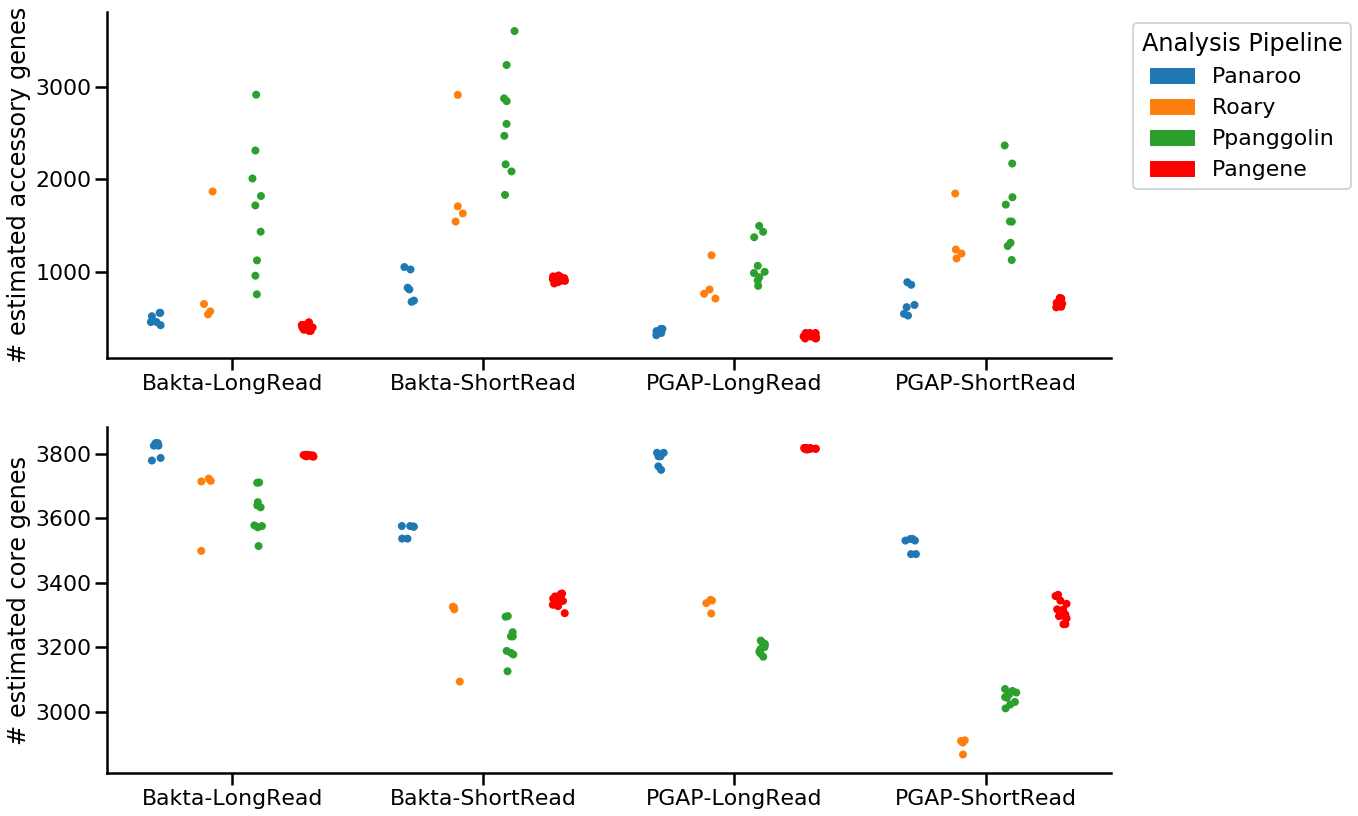

In [44]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)


sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Acc_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Acc_DF, fliersize=0,
#             hue_order = hue_Order_Tools,
#             #order = Order_AnnoAndType,
#             ax= axs[0], boxprops=dict(alpha=0.4, linewidth=0),  )

sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Core_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Core_DF, fliersize=0,
#             hue_order = hue_Order_Tools, #order = Order_AnnoAndType,
#             ax= axs[1], boxprops=dict(alpha=0.4, linewidth=0),  )

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

sns.despine()

plt.show()

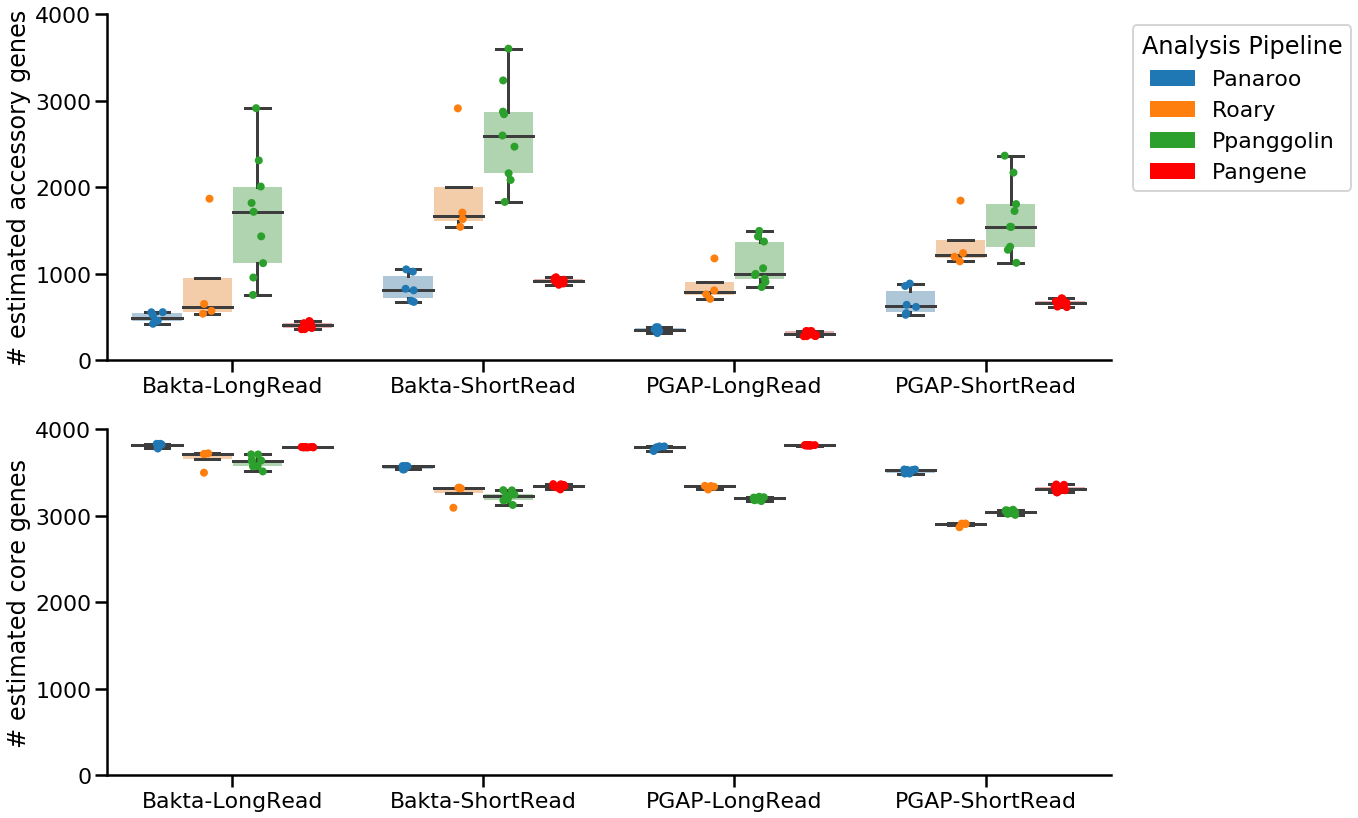

In [45]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)


sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Acc_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])

sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
            data = PG_Merged_Stats_LRandSR_Acc_DF, fliersize=0,
            hue_order = hue_Order_Tools,
            #order = Order_AnnoAndType,
            ax= axs[0], boxprops=dict(alpha=0.4, linewidth=0),  )

sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Core_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
            data = PG_Merged_Stats_LRandSR_Core_DF, fliersize=0,
            hue_order = hue_Order_Tools, #order = Order_AnnoAndType,
            ax= axs[1], boxprops=dict(alpha=0.4, linewidth=0),  )

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

axs[0].set_ylim(0, 4000)
axs[1].set_ylim(0, 4000)

sns.despine()

plt.show()

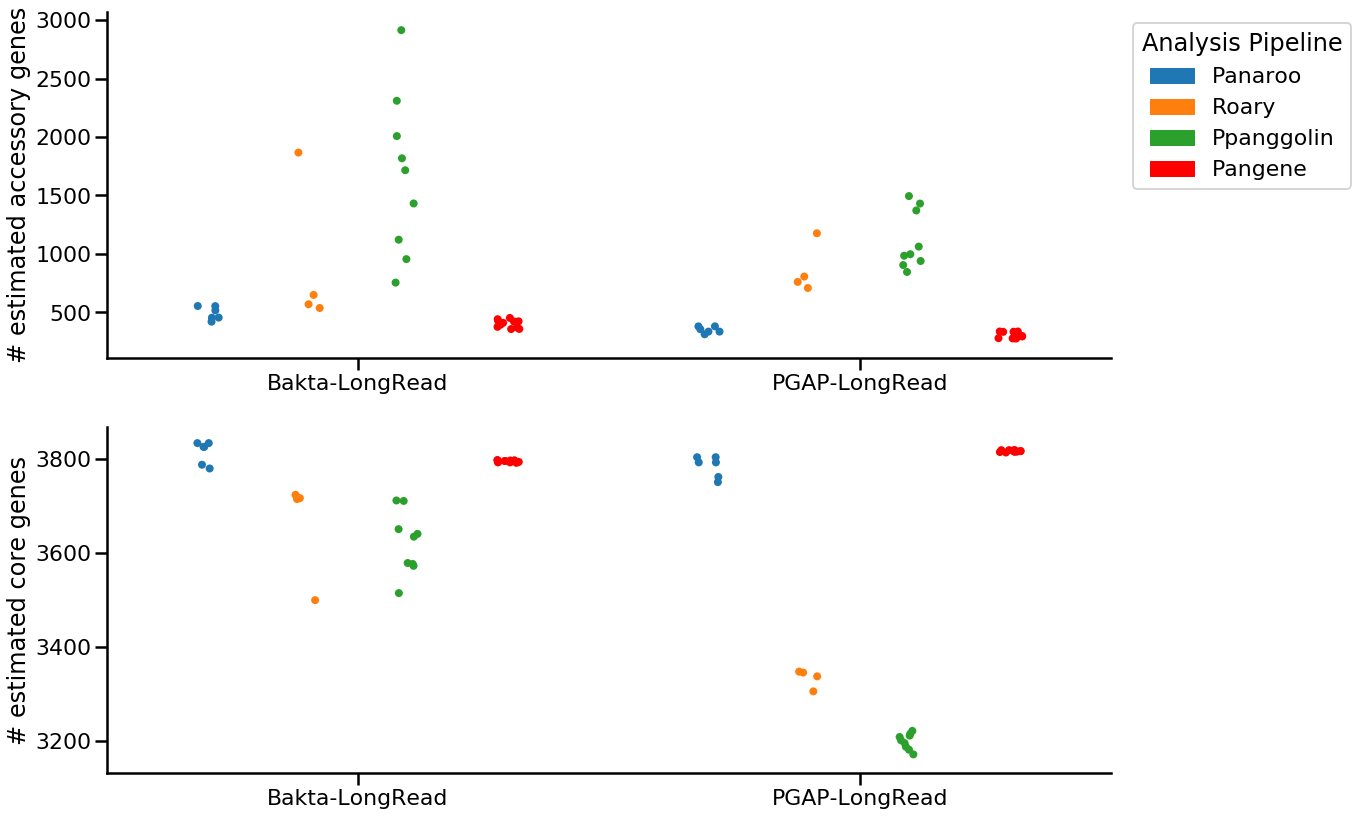

In [46]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)


sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LR_Acc_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Acc_DF, fliersize=0,
#             hue_order = hue_Order_Tools,
#             #order = Order_AnnoAndType,
#             ax= axs[0], boxprops=dict(alpha=0.4, linewidth=0),  )

sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LR_Core_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Core_DF, fliersize=0,
#             hue_order = hue_Order_Tools, #order = Order_AnnoAndType,
#             ax= axs[1], boxprops=dict(alpha=0.4, linewidth=0),  )

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

sns.despine()

plt.show()

In [47]:
PG_Merged_Stats_LR_Core_DF

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech,MethodAndTechAndAnno,AnnoAndTech,PangenomeTool
0,Core genes,(99% <= strains <= 100%),3779,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead,Panaroo_Strict_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
0,Core genes,(99% <= strains <= 100%),3825,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead,Panaroo_Moderate_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
0,Core genes,(99% <= strains <= 100%),3825,Bakta,Panaroo_Sensitive_MergeParalogs,LongRead,All,Panaroo_Sensitive_MergeParalogs_LongRead,Panaroo_Sensitive_MergeParalogs_LongRead_Bakta,Bakta-LongRead,Panaroo
0,Core genes,(99% <= strains <= 100%),3787,Bakta,Panaroo_Strict,LongRead,All,Panaroo_Strict_LongRead,Panaroo_Strict_LongRead_Bakta,Bakta-LongRead,Panaroo
0,Core genes,(99% <= strains <= 100%),3833,Bakta,Panaroo_Moderate,LongRead,All,Panaroo_Moderate_LongRead,Panaroo_Moderate_LongRead_Bakta,Bakta-LongRead,Panaroo
0,Core genes,(99% <= strains <= 100%),3833,Bakta,Panaroo_Sensitive,LongRead,All,Panaroo_Sensitive_LongRead,Panaroo_Sensitive_LongRead_Bakta,Bakta-LongRead,Panaroo
0,Core genes,(99% <= strains <= 100%),3714,Bakta,Roary_NoSplitParalogs_I80,LongRead,All,Roary_NoSplitParalogs_I80_LongRead,Roary_NoSplitParalogs_I80_LongRead_Bakta,Bakta-LongRead,Roary
0,Core genes,(99% <= strains <= 100%),3723,Bakta,Roary_NoSplitParalogs_I90,LongRead,All,Roary_NoSplitParalogs_I90_LongRead,Roary_NoSplitParalogs_I90_LongRead_Bakta,Bakta-LongRead,Roary
0,Core genes,(99% <= strains <= 100%),3716,Bakta,Roary_NoSplitParalogs,LongRead,All,Roary_NoSplitParalogs_LongRead,Roary_NoSplitParalogs_LongRead_Bakta,Bakta-LongRead,Roary
0,Core genes,(99% <= strains <= 100%),3499,Bakta,Roary_Default,LongRead,All,Roary_Default_LongRead,Roary_Default_LongRead_Bakta,Bakta-LongRead,Roary


# Viz Explore - V3

In [48]:
#PG_Merged_Stats_LRandSR_Acc_DF.head(4)

In [49]:
Tools_hue_Color_Dict = {"Panaroo": "#1f77b4",
                        "Roary": "#ff7f0e",
                        "Ppanggolin": "#2ca02c" ,
                        "Pangene": "red" }

Panaroo_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Panaroo"], label='Panaroo (N = 6)')
Roary_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Roary"], label='Roary (N = 4)')
Ppanggolin_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Ppanggolin"], label='Ppanggolin (N = 9)')
Pangene_patch = mpatches.Patch(color = Tools_hue_Color_Dict["Pangene"], label='Pangene (N = 12)')

ToolPatches_List = [Panaroo_patch, Roary_patch, Ppanggolin_patch, Pangene_patch]



hue_Order_Tools = ["Panaroo", "Roary", "Ppanggolin", "Pangene"]
Order_AnnoAndType = ['Bakta-LongRead', 'PGAP-LongRead', 'Bakta-ShortRead', 'PGAP-ShortRead']


mkdir: cannot create directory ‘Results3_Plots_Rev1/’: File exists


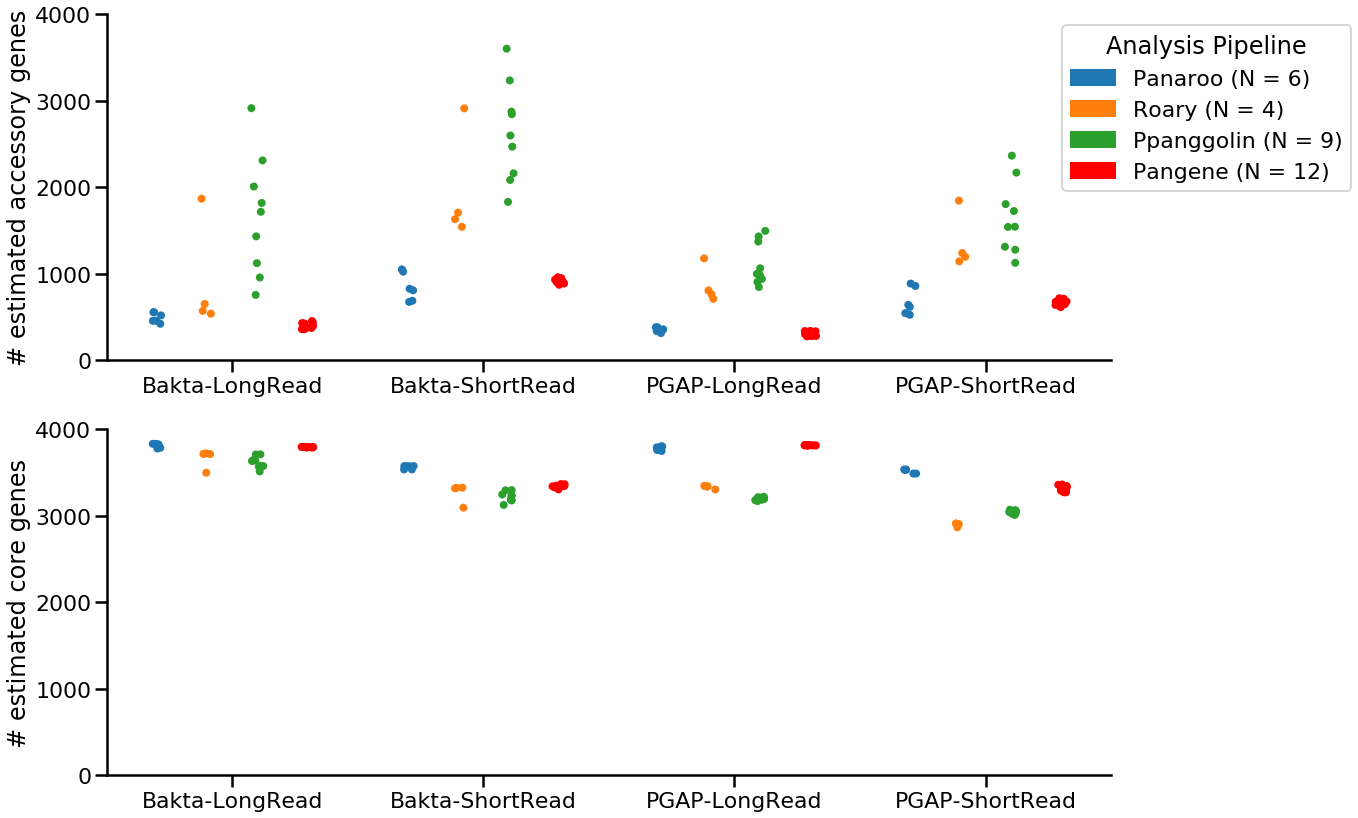

In [50]:
# Set the context for the plot
#sns.set_context("paper", font_scale=1.5)
sns.set_context("poster")

# Create a subplot
fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)


sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Acc_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[0])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Acc_DF, fliersize=0,
#             hue_order = hue_Order_Tools,
#             #order = Order_AnnoAndType,
#             ax= axs[0], boxprops=dict(alpha=0.4, linewidth=0),  )

sns.stripplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
              data = PG_Merged_Stats_LRandSR_Core_DF, linewidth=0, size = 8,
              #order = Order_AnnoAndType,
              palette = Tools_hue_Color_Dict, hue_order = hue_Order_Tools, 
              alpha=1, marker = "o", jitter = True, dodge = True, edgecolor='gray', ax= axs[1])

# sns.boxplot(y = "GeneCount", x = "AnnoAndTech", hue = "PangenomeTool",
#             data = PG_Merged_Stats_LRandSR_Core_DF, fliersize=0,
#             hue_order = hue_Order_Tools, #order = Order_AnnoAndType,
#             ax= axs[1], boxprops=dict(alpha=0.4, linewidth=0),  )

axs[0].set_xlabel(""), axs[1].set_xlabel("")
axs[0].set_ylabel("# estimated accessory genes"), axs[1].set_ylabel("# estimated core genes") 

axs[0].legend(title = "Analysis Pipeline",
              handles=ToolPatches_List,
              bbox_to_anchor=(1.25, 1))
axs[1].get_legend().remove()

axs[0].set_ylim(0, 4000)
axs[1].set_ylim(0, 4000)

sns.despine()

!mkdir Results3_Plots_Rev1/
plt.savefig("Results3_Plots_Rev1/3.PG.Counts.ColorByTool.stripplots.V2.png", dpi = 300, bbox_inches="tight")
plt.savefig("Results3_Plots_Rev1/3.PG.Counts.ColorByTool.stripplots.V2.svg", bbox_inches="tight")

plt.show()

In [51]:
PG_Merged_Stats_LRandSR_Acc_DF["PangenomeTool"].value_counts() / 4

Pangene       12.0
Ppanggolin     9.0
Panaroo        6.0
Roary          4.0
Name: PangenomeTool, dtype: float64

In [52]:
PG_Merged_Stats_LRandSR_Acc_DF["PangenomeTool"].value_counts() / 4

Pangene       12.0
Ppanggolin     9.0
Panaroo        6.0
Roary          4.0
Name: PangenomeTool, dtype: float64

In [53]:

PG_Merged_Stats_LRandSR_Acc_DF["Method"].value_counts() 



Panaroo_Strict_MergeParalogs       4
Ppanggolin_I0.98C0.60              4
Pangene_0.98.Miniprot0.99          4
Pangene_0.98.Miniprot0.98          4
Pangene_0.98.Miniprot0.95          4
Pangene_0.95.Miniprot0.9           4
Pangene_0.95.Miniprot0.99          4
Pangene_0.95.Miniprot0.98          4
Pangene_0.95.Miniprot0.95          4
Pangene_0.9.Miniprot0.9            4
Pangene_0.9.Miniprot0.99           4
Pangene_0.9.Miniprot0.98           4
Pangene_0.9.Miniprot0.95           4
Ppanggolin_I0.98C0.90              4
Ppanggolin_I0.98C0.80              4
Ppanggolin_I0.90C0.90              4
Panaroo_Moderate_MergeParalogs     4
Ppanggolin_I0.90C0.80              4
Ppanggolin_I0.90C0.60              4
Ppanggolin_I0.80C0.90              4
Ppanggolin_I0.80C0.80              4
Ppanggolin_I0.80C0.60              4
Roary_Default                      4
Roary_NoSplitParalogs              4
Roary_NoSplitParalogs_I90          4
Roary_NoSplitParalogs_I80          4
Panaroo_Sensitive                  4
P

# Viz results coloring by Anno-AsmType combinations

In [54]:
AnnoAndTech_hue_Color_BaktaOnly_Dict = {"Bakta-LongRead": "#1f77b4",
                                        "Bakta-ShortRead": "#ff7f0e", }


AnnoAndTech_hue_Color_Dict = { "Bakta-LongRead": "#1f77b4",
                               "PGAP-LongRead": "#2ca02c",
                               "Bakta-ShortRead": "#ff7f0e",
                               "PGAP-ShortRead": "#9467bd" }

Bakta_CompAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["Bakta-LongRead"],
                                     label='Bakta & Complete Assemblies (N=151)')
Bakta_SRAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["Bakta-ShortRead"],
                                   label='Bakta & Short-Read Assemblies (N=151)')
PGAP_CompAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["PGAP-LongRead"],
                                    label='PGAP & Complete Assemblies (N=151)')
PGAP_SRAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["PGAP-ShortRead"],
                                  label='PGAP & Short-Read Assemblies (N=151)')

AnnoAndTech_Patches = [Bakta_CompAsm_patch, PGAP_CompAsm_patch, Bakta_SRAsm_patch, PGAP_SRAsm_patch]

AnnoAndTech_BaktaOnly_Patches = [Bakta_CompAsm_patch, Bakta_SRAsm_patch]

hue_orderToPlot_V2 = ["Bakta-LongRead",  "PGAP-LongRead", "Bakta-ShortRead", "PGAP-ShortRead"]

#hue_orderToPlot_X = AnnoAndTech_hue_Color_Dict.keys()
#pallete_ForPlot = AnnoAndTech_hue_Color_Dict.values()


In [55]:
hue_orderToPlot_V2

['Bakta-LongRead', 'PGAP-LongRead', 'Bakta-ShortRead', 'PGAP-ShortRead']

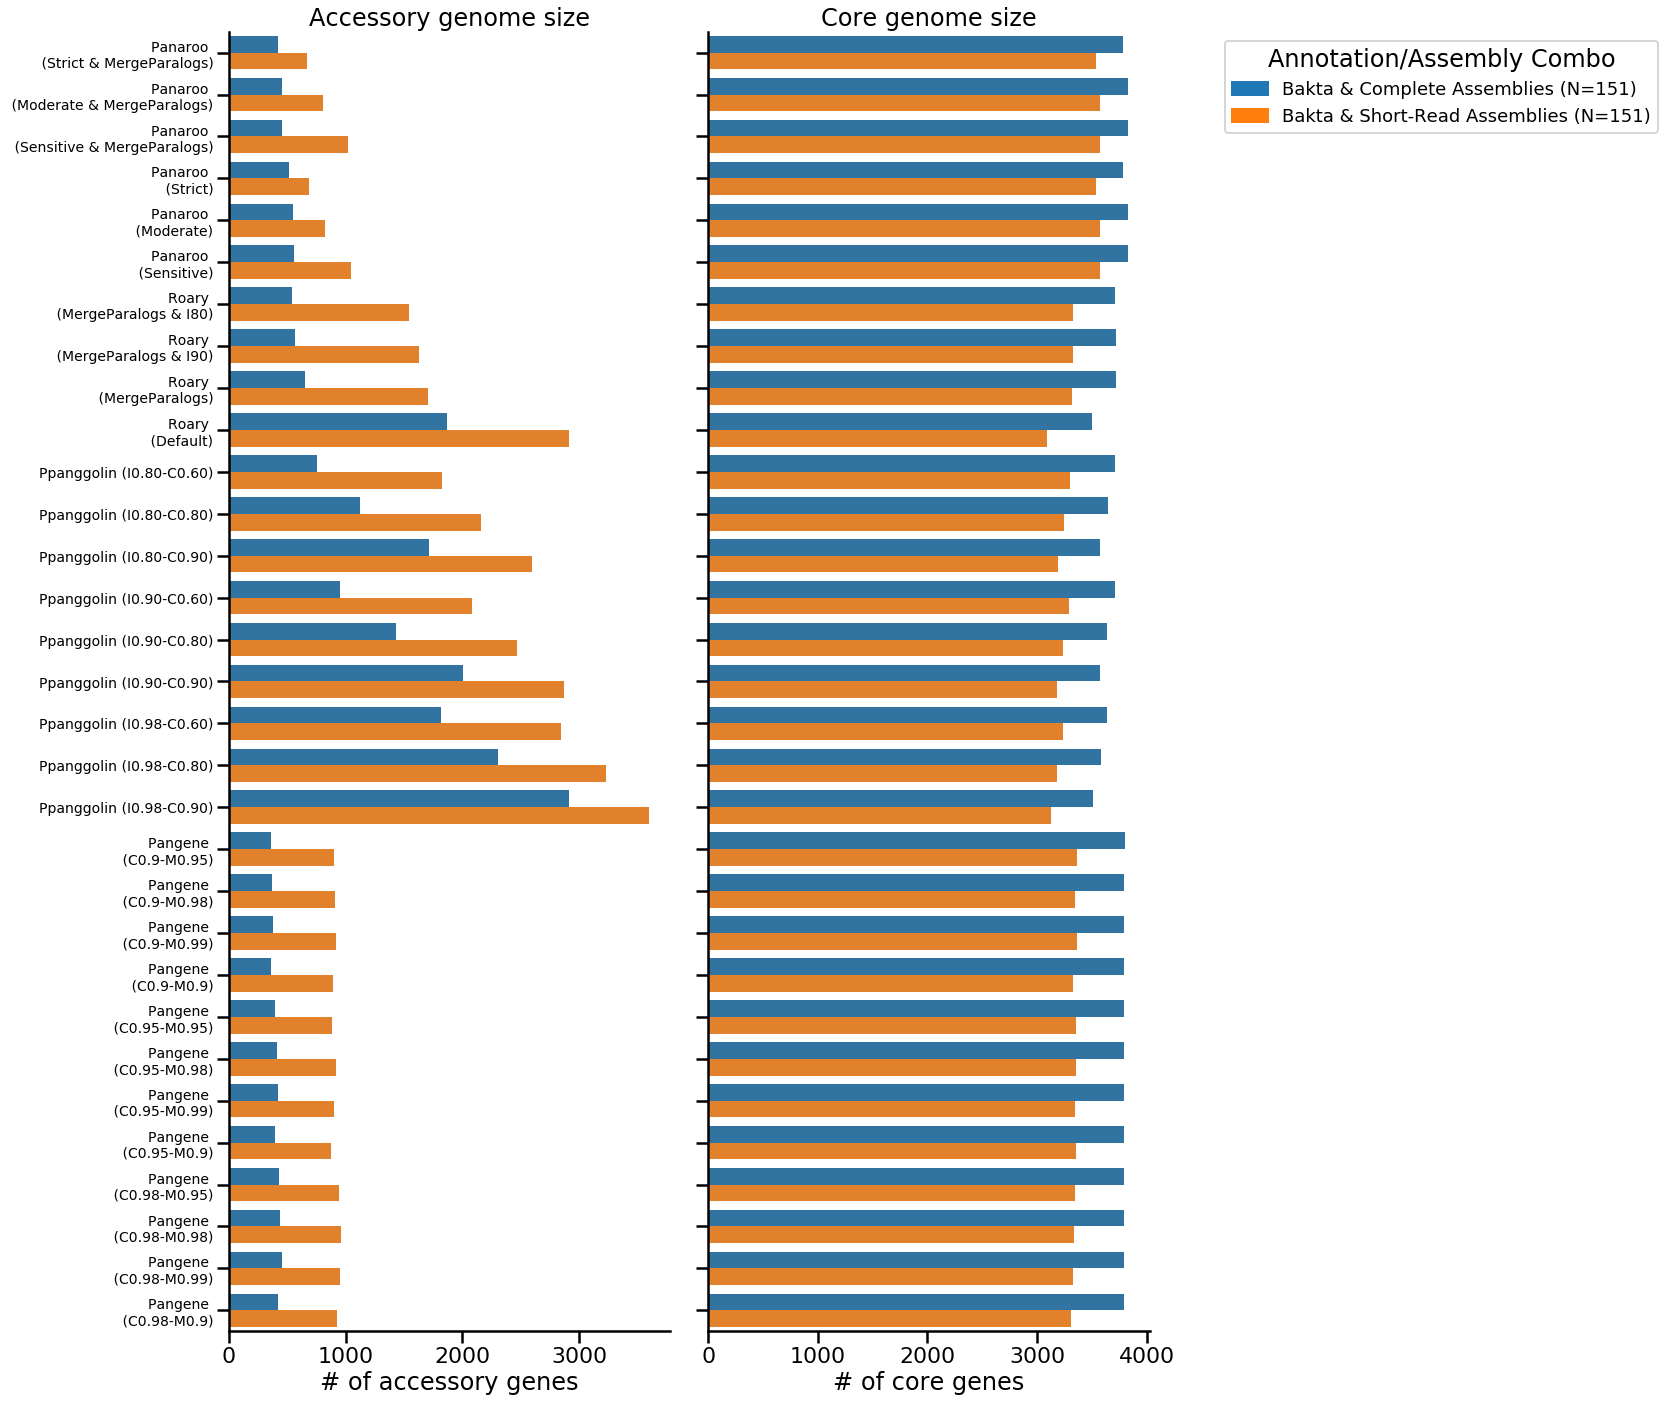

In [56]:
# Change the subplot configuration to 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(24, 20), sharex=False, sharey=True)
sns.set_context("poster")

hue_orderToPlot_X = AnnoAndTech_hue_Color_BaktaOnly_Dict.keys()
pallete_ForPlot = AnnoAndTech_hue_Color_BaktaOnly_Dict.values()


# Plotting on the first and second subplot
sns.barplot(y="Method", x="GeneCount", hue="AnnoAndTech", data=PG_Merged_Stats_LRandSR_Acc_DF.query("Annotation == 'Bakta' "),
            order=PipeName_WiParam_List, hue_order=hue_orderToPlot_X, ax=axs[0], palette=pallete_ForPlot)

sns.barplot(y="Method", x="GeneCount", hue="AnnoAndTech", data=PG_Merged_Stats_LRandSR_Core_DF.query("Annotation == 'Bakta' "),
            order=PipeName_WiParam_List, hue_order=hue_orderToPlot_X, ax=axs[1], palette=pallete_ForPlot)


# Set labels
axs[0].set_ylabel("") # Adjust as needed
axs[1].set_ylabel("") # Adjust as needed
axs[0].set_xlabel("# of accessory genes", rotation=0)
axs[1].set_xlabel("# of core genes", rotation=0)

# Set tick labels
for i_ax in axs:
    i_ax.set_yticklabels(labels=PGCombos_TickLabels, rotation=0, fontdict={"fontsize": 14})

axs[1].legend(title = "Annotation/Assembly Combo",
              handles = AnnoAndTech_BaktaOnly_Patches,
              bbox_to_anchor=(1.15, 1),
              fontsize= 18) 

axs[0].get_legend().remove(), 

# Set titles
axs[0].set_title("Accessory genome size")
axs[1].set_title("Core genome size")

# Despine and layout adjustment
sns.despine()
plt.tight_layout()

plt.show()

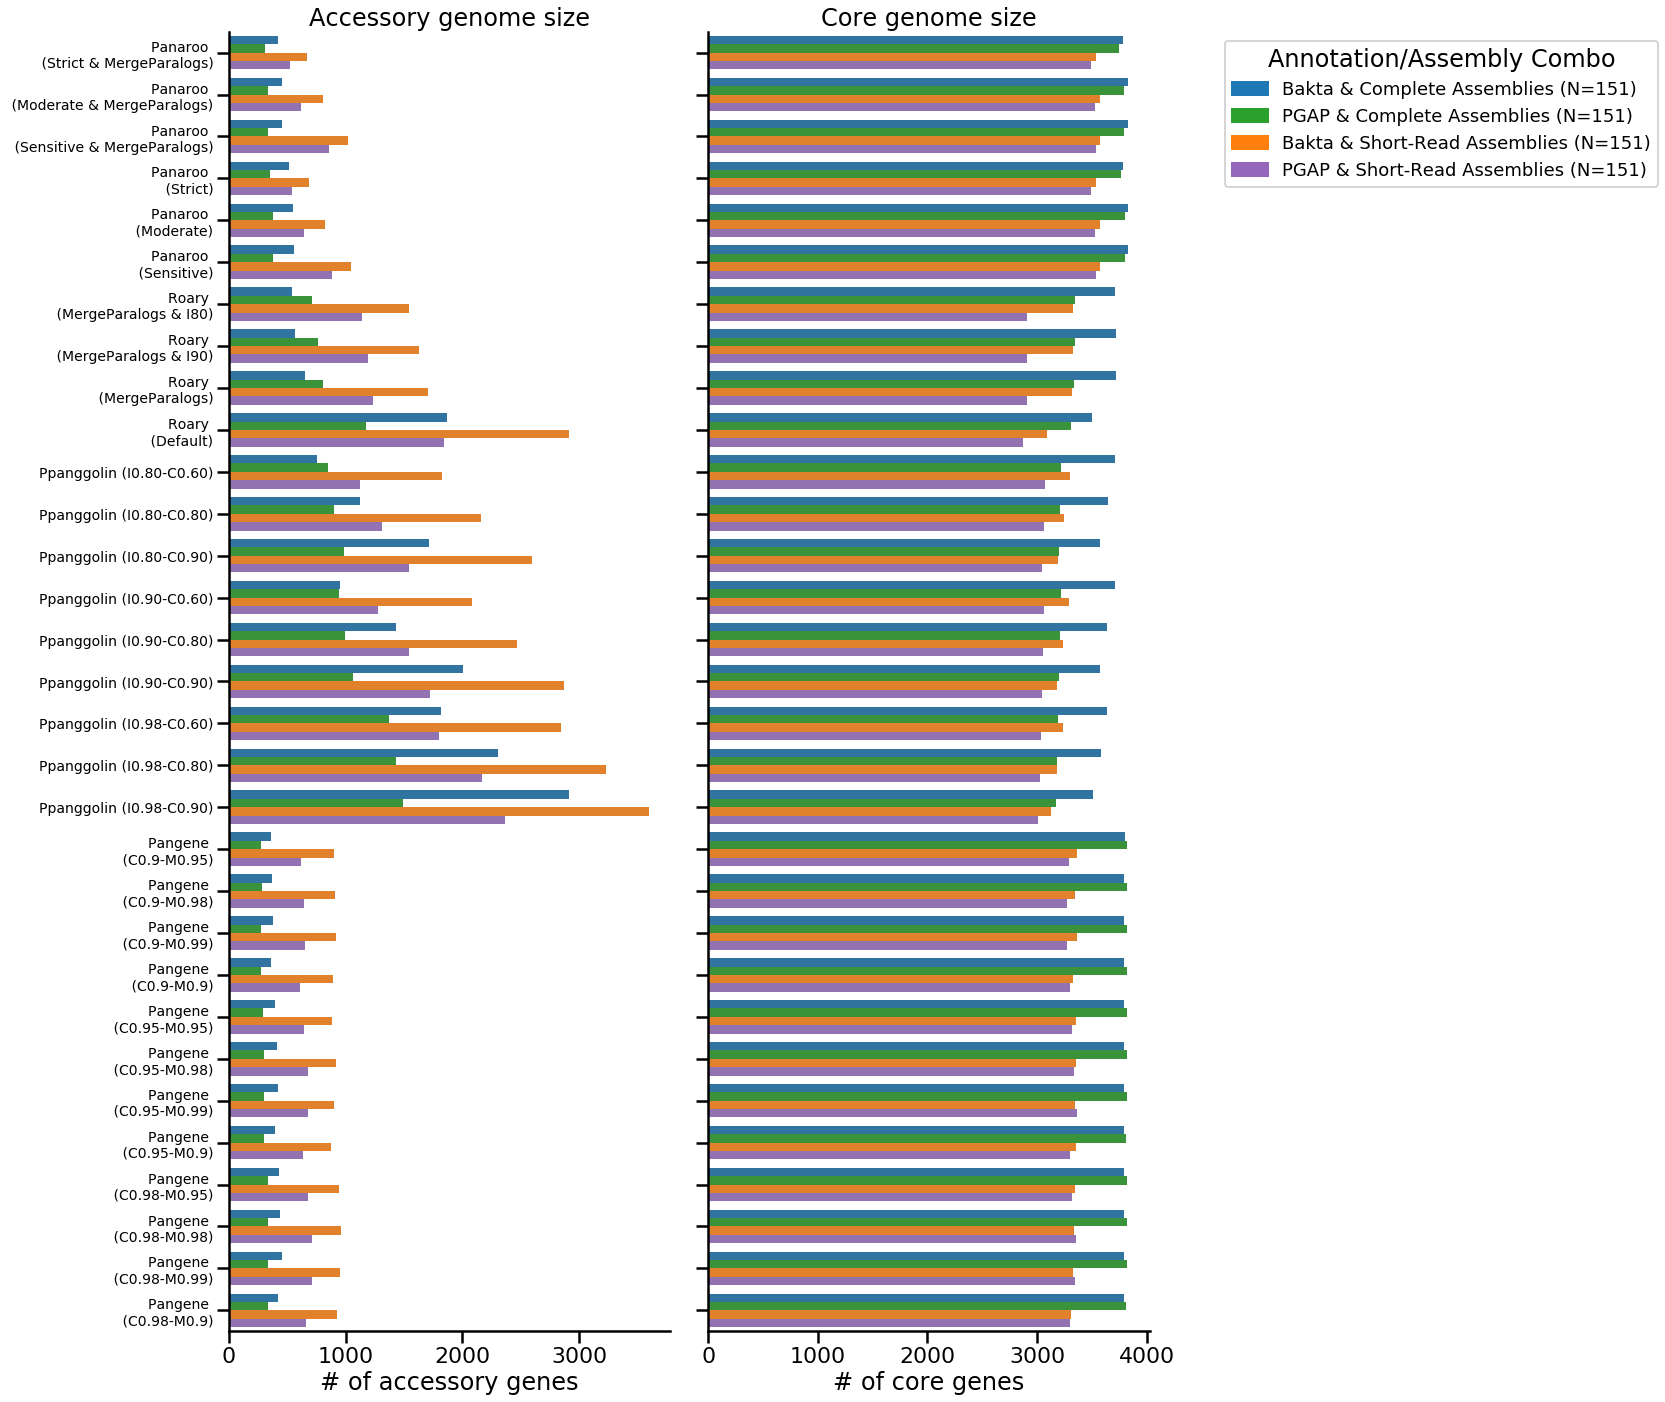

In [57]:
# Change the subplot configuration to 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(24, 20), sharex=False, sharey=True)
sns.set_context("poster")

hue_orderToPlot_X = AnnoAndTech_hue_Color_Dict.keys()
pallete_ForPlot = AnnoAndTech_hue_Color_Dict.values()

# Plotting on the first and second subplot
sns.barplot(y="Method", x="GeneCount", hue="AnnoAndTech", data=PG_Merged_Stats_LRandSR_Acc_DF,
            order=PipeName_WiParam_List, hue_order=hue_orderToPlot_V2, ax=axs[0], palette=pallete_ForPlot)

sns.barplot(y="Method", x="GeneCount", hue="AnnoAndTech", data=PG_Merged_Stats_LRandSR_Core_DF,
            order=PipeName_WiParam_List, hue_order=hue_orderToPlot_V2, ax=axs[1], palette=pallete_ForPlot)

# Set labels
axs[0].set_ylabel("") # Adjust as needed
axs[1].set_ylabel("") # Adjust as needed
axs[0].set_xlabel("# of accessory genes", rotation=0)
axs[1].set_xlabel("# of core genes", rotation=0)

# Set tick labels
for i_ax in axs:
    i_ax.set_yticklabels(labels=PGCombos_TickLabels, rotation=0, fontdict={"fontsize": 14})

axs[1].legend(title = "Annotation/Assembly Combo", handles = AnnoAndTech_Patches,
              bbox_to_anchor=(1.15, 1), fontsize= 18) 
axs[0].get_legend().remove(), 

# Set titles
axs[0].set_title("Accessory genome size")
axs[1].set_title("Core genome size")

# Despine and layout adjustment
sns.despine()
plt.tight_layout()

plt.savefig("Results3_Plots_Rev1/3.PG.Counts.SRvsLR.AND.BaktaVsPGAP.CombinedCoreAccPlots.png", dpi = 300, bbox_inches="tight")
plt.savefig("Results3_Plots_Rev1/3.PG.Counts.SRvsLR.AND.BaktaVsPGAP.CombinedCoreAccPlots.svg", bbox_inches="tight")

plt.show()

In [58]:
PG_WideSumm_DF["Total genes"].describe()  

count     124.000000
mean     4477.620968
std       593.317867
min      3910.000000
25%      4128.000000
50%      4237.000000
75%      4597.750000
max      6728.000000
Name: Total genes, dtype: float64

In [59]:
PG_WideSumm_DF["Accessory genes"].describe()  

count     124.000000
mean     1012.395161
std       721.692048
min       277.000000
25%       454.500000
50%       817.000000
75%      1285.750000
max      3602.000000
Name: Accessory genes, dtype: float64

In [60]:
PG_WideSumm_DF["Core genes"].describe()  

count     124.000000
mean     3465.225806
std       277.320478
min      2868.000000
25%      3272.000000
50%      3366.000000
75%      3791.250000
max      3833.000000
Name: Core genes, dtype: float64

In [68]:
PG_WideSumm_DF.query("PangenomeTool == 'Ppanggolin'").sort_values("Accessory genes", ascending=False).head(3)

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
115,Ppanggolin,ShortRead,Bakta,Ppanggolin_I0.98C0.90,6728,3126,3602
114,Ppanggolin,ShortRead,Bakta,Ppanggolin_I0.98C0.80,6418,3183,3235
53,Ppanggolin,LongRead,Bakta,Ppanggolin_I0.98C0.90,6428,3514,2914


In [69]:
PG_WideSumm_DF.query("PangenomeTool == 'Ppanggolin'").sort_values("Accessory genes", ascending=True).head(3)

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
36,Ppanggolin,LongRead,Bakta,Ppanggolin_I0.80C0.60,4466,3711,755
37,Ppanggolin,LongRead,PGAP,Ppanggolin_I0.80C0.60,4061,3215,846
38,Ppanggolin,LongRead,PGAP,Ppanggolin_I0.80C0.80,4113,3208,905


In [71]:
PG_WideSumm_DF.query("PangenomeTool == 'Roary'").sort_values("Accessory genes", ascending=False).head(3)

,PangenomeTool,SeqType,Anno,Method,Total genes,Core genes,Accessory genes
123,Roary,ShortRead,Bakta,Roary_Default,6006,3094,2912
61,Roary,LongRead,Bakta,Roary_Default,5366,3499,1867
122,Roary,ShortRead,PGAP,Roary_Default,4713,2868,1845


In [140]:
PG_WideSumm_DF.groupby(["SeqType", "Anno"])["Total genes"].describe()  

count         mean         std     min     25%     50%     75%     max
SeqType   Anno                                                                         
LongRead  Bakta   31.0  4584.032258  599.588386  4154.0  4209.5  4281.0  4719.0  6428.0
          PGAP    31.0  4188.903226  160.972328  4056.0  4109.5  4128.0  4182.0  4666.0
ShortRead Bakta   31.0  4873.774194  776.786702  4211.0  4263.5  4400.0  5393.5  6728.0
          PGAP    31.0  4263.774194  383.706025  3910.0  4004.5  4106.0  4408.0  5376.0

In [141]:
PG_WideSumm_DF.groupby(["SeqType", "Anno"])["Accessory genes"].describe()  

count         mean         std    min    25%    50%     75%     max
SeqType   Anno                                                                      
LongRead  Bakta   31.0   853.354839  690.138515  358.0  422.0  518.0  1039.0  2914.0
          PGAP    31.0   620.645161  396.384287  277.0  306.0  357.0   922.5  1495.0
ShortRead Bakta   31.0  1533.677419  875.330886  674.0  902.5  959.0  2122.5  3602.0
          PGAP    31.0  1041.903226  519.049475  525.0  646.5  716.0  1294.5  2365.0

In [142]:
PG_WideSumm_DF.groupby(["SeqType", "Anno"])["Core genes"].describe()  

count         mean         std     min     25%     50%     75%     max
SeqType   Anno                                                                         
LongRead  Bakta   31.0  3730.677419   98.555023  3499.0  3680.0  3791.0  3796.0  3833.0
          PGAP    31.0  3568.258065  286.838046  3171.0  3218.0  3792.0  3815.0  3818.0
ShortRead Bakta   31.0  3340.096774  131.407345  3094.0  3271.0  3329.0  3361.5  3576.0
          PGAP    31.0  3221.870968  211.902138  2868.0  3045.0  3290.0  3352.0  3536.0

In [143]:
PG_WideSumm_DF.groupby(["SeqType", "Anno", "PangenomeTool"])["Core genes"].describe()  

count         mean         std     min      25%     50%      75%     max
SeqType   Anno  PangenomeTool                                                                          
LongRead  Bakta Panaroo          6.0  3813.666667   24.155055  3779.0  3796.50  3825.0  3831.00  3833.0
                Pangene         12.0  3794.333333    2.015095  3791.0  3792.75  3795.0  3796.00  3797.0
                Ppanggolin       9.0  3620.555556   66.251625  3514.0  3576.00  3634.0  3650.00  3711.0
                Roary            4.0  3663.000000  109.401402  3499.0  3660.25  3715.0  3717.75  3723.0
          PGAP  Panaroo          6.0  3783.500000   22.509998  3750.0  3768.75  3792.0  3800.25  3803.0
                Pangene         12.0  3815.916667    1.729862  3813.0  3815.00  3815.5  3818.00  3818.0
                Ppanggolin       9.0  3198.888889   16.721576  3171.0  3187.00  3201.0  3211.00  3221.0
                Roary            4.0  3333.500000   19.485037  3305.0  3329.00  3341.0  3345.50  3347.0
ShortRead Bakta Panaroo          6.0  3562.333333   19.643489  3537.0  3546.25  3574.0  3575.50  3576.0
                Pangene         12.0  3343.666667   17.624019  3306.0  3331.25  3346.5  3355.00  3367.0
                Ppanggolin       9.0  3220.333333   56.572962  3126.0  3183.00  3234.0  3247.00  3297.0
                Roary            4.0  3265.500000  114.383857  3094.0  3262.00  3321.0  3324.50  3326.0
          PGAP  Panaroo          6.0  3518.666667   23.088237  3489.0  3499.50  3531.0  3534.75  3536.0
                Pangene         12.0  3313.833333   31.208488  3272.0  3294.50  3309.5  3337.50  3363.0
                Ppanggolin       9.0  3045.000000   20.062403  3011.0  3031.00  3046.0  3060.00  3071.0
                Roary            4.0  2898.750000   20.710303  2868.0  2895.75  2907.5  2910.50  2912.0

In [144]:
PG_WideSumm_DF.groupby(["SeqType", "Anno", "PangenomeTool"])["Accessory genes"].describe()  

count         mean         std     min      25%     50%      75%     max
SeqType   Anno  PangenomeTool                                                                          
LongRead  Bakta Panaroo          6.0   493.166667   56.897862   421.0   455.25   487.0   545.00   555.0
                Pangene         12.0   403.250000   31.977620   358.0   375.75   404.0   425.00   453.0
                Ppanggolin       9.0  1670.111111  689.145203   755.0  1122.00  1716.0  2008.00  2914.0
                Roary            4.0   906.250000  642.229645   538.0   562.00   610.0   954.25  1867.0
          PGAP  Panaroo          6.0   350.666667   27.310560   313.0   336.00   346.5   375.00   381.0
                Pangene         12.0   303.916667   24.905123   277.0   279.75   298.0   334.25   337.0
                Ppanggolin       9.0  1115.000000  247.660049   846.0   940.00   998.0  1372.00  1495.0
                Roary            4.0   863.500000  212.799593   709.0   748.00   784.0   899.50  1177.0
ShortRead Bakta Panaroo          6.0   844.833333  161.245672   674.0   717.25   817.0   974.50  1050.0
                Pangene         12.0   915.583333   26.575650   872.0   897.75   915.5   933.75   959.0
                Ppanggolin       9.0  2633.000000  570.206322  1830.0  2161.00  2598.0  2874.00  3602.0
                Roary            4.0  1947.750000  646.358195  1542.0  1608.00  1668.5  2008.25  2912.0
          PGAP  Panaroo          6.0   678.166667  156.407694   525.0   562.00   628.0   803.50   886.0
                Pangene         12.0   662.000000   31.869050   614.0   644.25   658.5   679.25   716.0
                Ppanggolin       9.0  1651.444444  412.537305  1126.0  1312.00  1543.0  1805.00  2365.0
                Roary            4.0  1355.750000  328.521308  1143.0  1182.75  1217.5  1390.50  1845.0

In [72]:
PG_WideSumm_DF.groupby(["SeqType", "PangenomeTool"])["Total genes"].describe()  

count         mean         std     min      25%     50%      75%     max
SeqType   PangenomeTool                                                                          
LongRead  Panaroo         12.0  4220.500000  106.868228  4063.0  4128.00  4192.0  4287.00  4388.0
          Pangene         24.0  4158.708333   48.470950  4093.0  4115.25  4153.0  4195.00  4245.0
          Ppanggolin      18.0  4802.277778  680.512420  4061.0  4222.75  4639.0  5237.00  6428.0
          Roary            8.0  4383.125000  421.293734  4056.0  4134.50  4272.5  4395.00  5366.0
ShortRead Panaroo         12.0  4302.000000  200.794784  4014.0  4165.00  4303.0  4405.50  4626.0
          Pangene         24.0  4117.541667  151.405582  3910.0  3964.75  4144.0  4262.75  4291.0
          Ppanggolin      18.0  5274.888889  743.947728  4197.0  4640.00  5284.0  5766.00  6728.0
          Roary            8.0  4733.875000  651.738212  4055.0  4134.50  4789.5  4973.25  6006.0

In [78]:
PG_WideSumm_DF.groupby(["PangenomeTool"])["Accessory genes"].describe()  

,count,mean,std,min,25%,50%,75%,max
PangenomeTool,,,,,,,,
Panaroo,24.0,591.708333,219.523888,313.0,411.00,549.0,717.25,1050.0
Pangene,48.0,571.187500,242.105890,277.0,352.75,533.5,755.00,959.0
Ppanggolin,36.0,1767.388889,737.424680,755.0,1125.00,1629.5,2204.25,3602.0
Roary,16.0,1268.312500,632.840972,538.0,748.00,1186.5,1649.25,2912.0


In [61]:
PG_WideSumm_DF.groupby(["SeqType", "PangenomeTool"])["Accessory genes"].describe()  

count         mean         std     min      25%     50%      75%     max
SeqType   PangenomeTool                                                                          
LongRead  Panaroo         12.0   421.916667   85.724144   313.0   351.75   401.0   471.50   555.0
          Pangene         24.0   353.583333   57.963194   277.0   298.00   347.5   400.50   453.0
          Ppanggolin      18.0  1392.555556  577.862209   755.0   963.25  1247.0  1660.75  2914.0
          Roary            8.0   884.875000  443.505979   538.0   630.00   735.0   899.50  1867.0
ShortRead Panaroo         12.0   761.500000  174.681789   525.0   634.00   747.5   865.00  1050.0
          Pangene         24.0   788.791667  132.659741   614.0   660.75   794.0   914.25   959.0
          Ppanggolin      18.0  2142.222222  698.658762  1126.0  1588.50  2122.5  2565.75  3602.0
          Roary            8.0  1651.750000  570.468917  1143.0  1228.25  1586.0  1741.50  2912.0

In [62]:
PG_WideSumm_DF.groupby(["PangenomeTool"])["Accessory genes"].describe()  

,count,mean,std,min,25%,50%,75%,max
PangenomeTool,,,,,,,,
Panaroo,24.0,591.708333,219.523888,313.0,411.00,549.0,717.25,1050.0
Pangene,48.0,571.187500,242.105890,277.0,352.75,533.5,755.00,959.0
Ppanggolin,36.0,1767.388889,737.424680,755.0,1125.00,1629.5,2204.25,3602.0
Roary,16.0,1268.312500,632.840972,538.0,748.00,1186.5,1649.25,2912.0


In [63]:
PG_WideSumm_DF.groupby(["SeqType"])["Accessory genes"].describe()  

,count,mean,std,min,25%,50%,75%,max
SeqType,,,,,,,,
LongRead,62.0,737.000000,570.328263,277.0,357.25,454.0,952.00,2914.0
ShortRead,62.0,1287.790323,755.494022,525.0,692.75,937.5,1687.75,3602.0


In [64]:
1287.790323	- 737.000000

550.790323

In [65]:
PG_WideSumm_DF.groupby(["SeqType"])["Core genes"].describe()  

,count,mean,std,min,25%,50%,75%,max
SeqType,,,,,,,,
LongRead,62.0,3649.467742,227.911596,3171.0,3573.00,3791.5,3810.50,3833.0
ShortRead,62.0,3280.983871,184.735566,2868.0,3179.25,3317.5,3358.75,3576.0


In [66]:
3280.983871 - 3649.467742

-368.4838709999999

In [75]:
PG_WideSumm_DF.query("PangenomeTool == 'Ppanggolin'").groupby(["SeqType",  "Anno", "PangenomeTool"])["Total genes"].describe()  

count         mean         std     min     25%     50%     75%     max
SeqType   Anno  PangenomeTool                                                                        
LongRead  Bakta Ppanggolin       9.0  5290.666667  627.215274  4466.0  4772.0  5292.0  5580.0  6428.0
          PGAP  Ppanggolin       9.0  4313.888889  232.387846  4061.0  4161.0  4209.0  4559.0  4666.0
ShortRead Bakta Ppanggolin       9.0  5853.333333  518.616911  5127.0  5408.0  5787.0  6078.0  6728.0
          PGAP  Ppanggolin       9.0  4696.444444  392.797375  4197.0  4372.0  4597.0  4836.0  5376.0

In [76]:
PG_WideSumm_DF.query("PangenomeTool == 'Pangene'").groupby(["SeqType",  "Anno", "PangenomeTool"])["Total genes"].describe()  

count         mean        std     min      25%     50%      75%     max
SeqType   Anno  PangenomeTool                                                                         
LongRead  Bakta Pangene         12.0  4197.583333  31.738873  4154.0  4167.25  4198.0  4221.00  4245.0
          PGAP  Pangene         12.0  4119.833333  24.653354  4093.0  4095.00  4114.5  4150.00  4152.0
ShortRead Bakta Pangene         12.0  4259.250000  25.161749  4219.0  4242.75  4263.5  4279.75  4291.0
          PGAP  Pangene         12.0  3975.833333  59.029782  3910.0  3924.00  3964.5  4018.75  4069.0

In [73]:
PG_WideSumm_DF.groupby(["SeqType",  "Anno", "PangenomeTool"])["Total genes"].describe()  

count         mean         std     min      25%     50%      75%     max
SeqType   Anno  PangenomeTool                                                                          
LongRead  Bakta Panaroo          6.0  4306.833333   71.859353  4200.0  4280.25  4293.0  4366.50  4388.0
                Pangene         12.0  4197.583333   31.738873  4154.0  4167.25  4198.0  4221.00  4245.0
                Ppanggolin       9.0  5290.666667  627.215274  4466.0  4772.00  5292.0  5580.00  6428.0
                Roary            4.0  4569.250000  533.255020  4252.0  4282.75  4329.5  4616.00  5366.0
          PGAP  Panaroo          6.0  4134.166667   45.538628  4063.0  4120.50  4128.0  4170.00  4184.0
                Pangene         12.0  4119.833333   24.653354  4093.0  4095.00  4114.5  4150.00  4152.0
                Ppanggolin       9.0  4313.888889  232.387846  4061.0  4161.00  4209.0  4559.00  4666.0
                Roary            4.0  4197.000000  193.387349  4056.0  4093.50  4125.0  4228.50  4482.0
ShortRead Bakta Panaroo          6.0  4407.166667  177.645058  4211.0  4263.50  4391.0  4550.00  4626.0
                Pangene         12.0  4259.250000   25.161749  4219.0  4242.75  4263.5  4279.75  4291.0
                Ppanggolin       9.0  5853.333333  518.616911  5127.0  5408.00  5787.0  6078.00  6728.0
                Roary            4.0  5213.250000  532.494366  4866.0  4933.50  4990.5  5270.25  6006.0
          PGAP  Panaroo          6.0  4196.833333  174.925603  4014.0  4061.50  4159.0  4338.25  4422.0
                Pangene         12.0  3975.833333   59.029782  3910.0  3924.00  3964.5  4018.75  4069.0
                Ppanggolin       9.0  4696.444444  392.797375  4197.0  4372.00  4597.0  4836.00  5376.0
                Roary            4.0  4254.500000  307.833830  4055.0  4093.25  4125.0  4286.25  4713.0

In [74]:
PG_WideSumm_DF.groupby(["SeqType",  "Anno"])["Total genes"].describe()  

count         mean         std     min     25%     50%     75%     max
SeqType   Anno                                                                         
LongRead  Bakta   31.0  4584.032258  599.588386  4154.0  4209.5  4281.0  4719.0  6428.0
          PGAP    31.0  4188.903226  160.972328  4056.0  4109.5  4128.0  4182.0  4666.0
ShortRead Bakta   31.0  4873.774194  776.786702  4211.0  4263.5  4400.0  5393.5  6728.0
          PGAP    31.0  4263.774194  383.706025  3910.0  4004.5  4106.0  4408.0  5376.0